In [2]:
# Lasciate questa cella così ogni volta che aggiornate un file python, 
# anche gli import nel notebook vengono aggiornati

%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np

from Utils import *
from constants import *

from Scenario import *
from Environment import *
from Non_Stationary_Environment import *

from Social_influence import *
from Network import Network

from Simulation import *

from Ecommerce import *
from Ecommerce3 import *
from Ecommerce4 import *
from Ecommerce5 import *
from Ecommerce6 import *
from step7.Ecommerce7 import *

n_iteration: 100%|██████████| 70/70 [07:42<00:00,  6.61s/it]


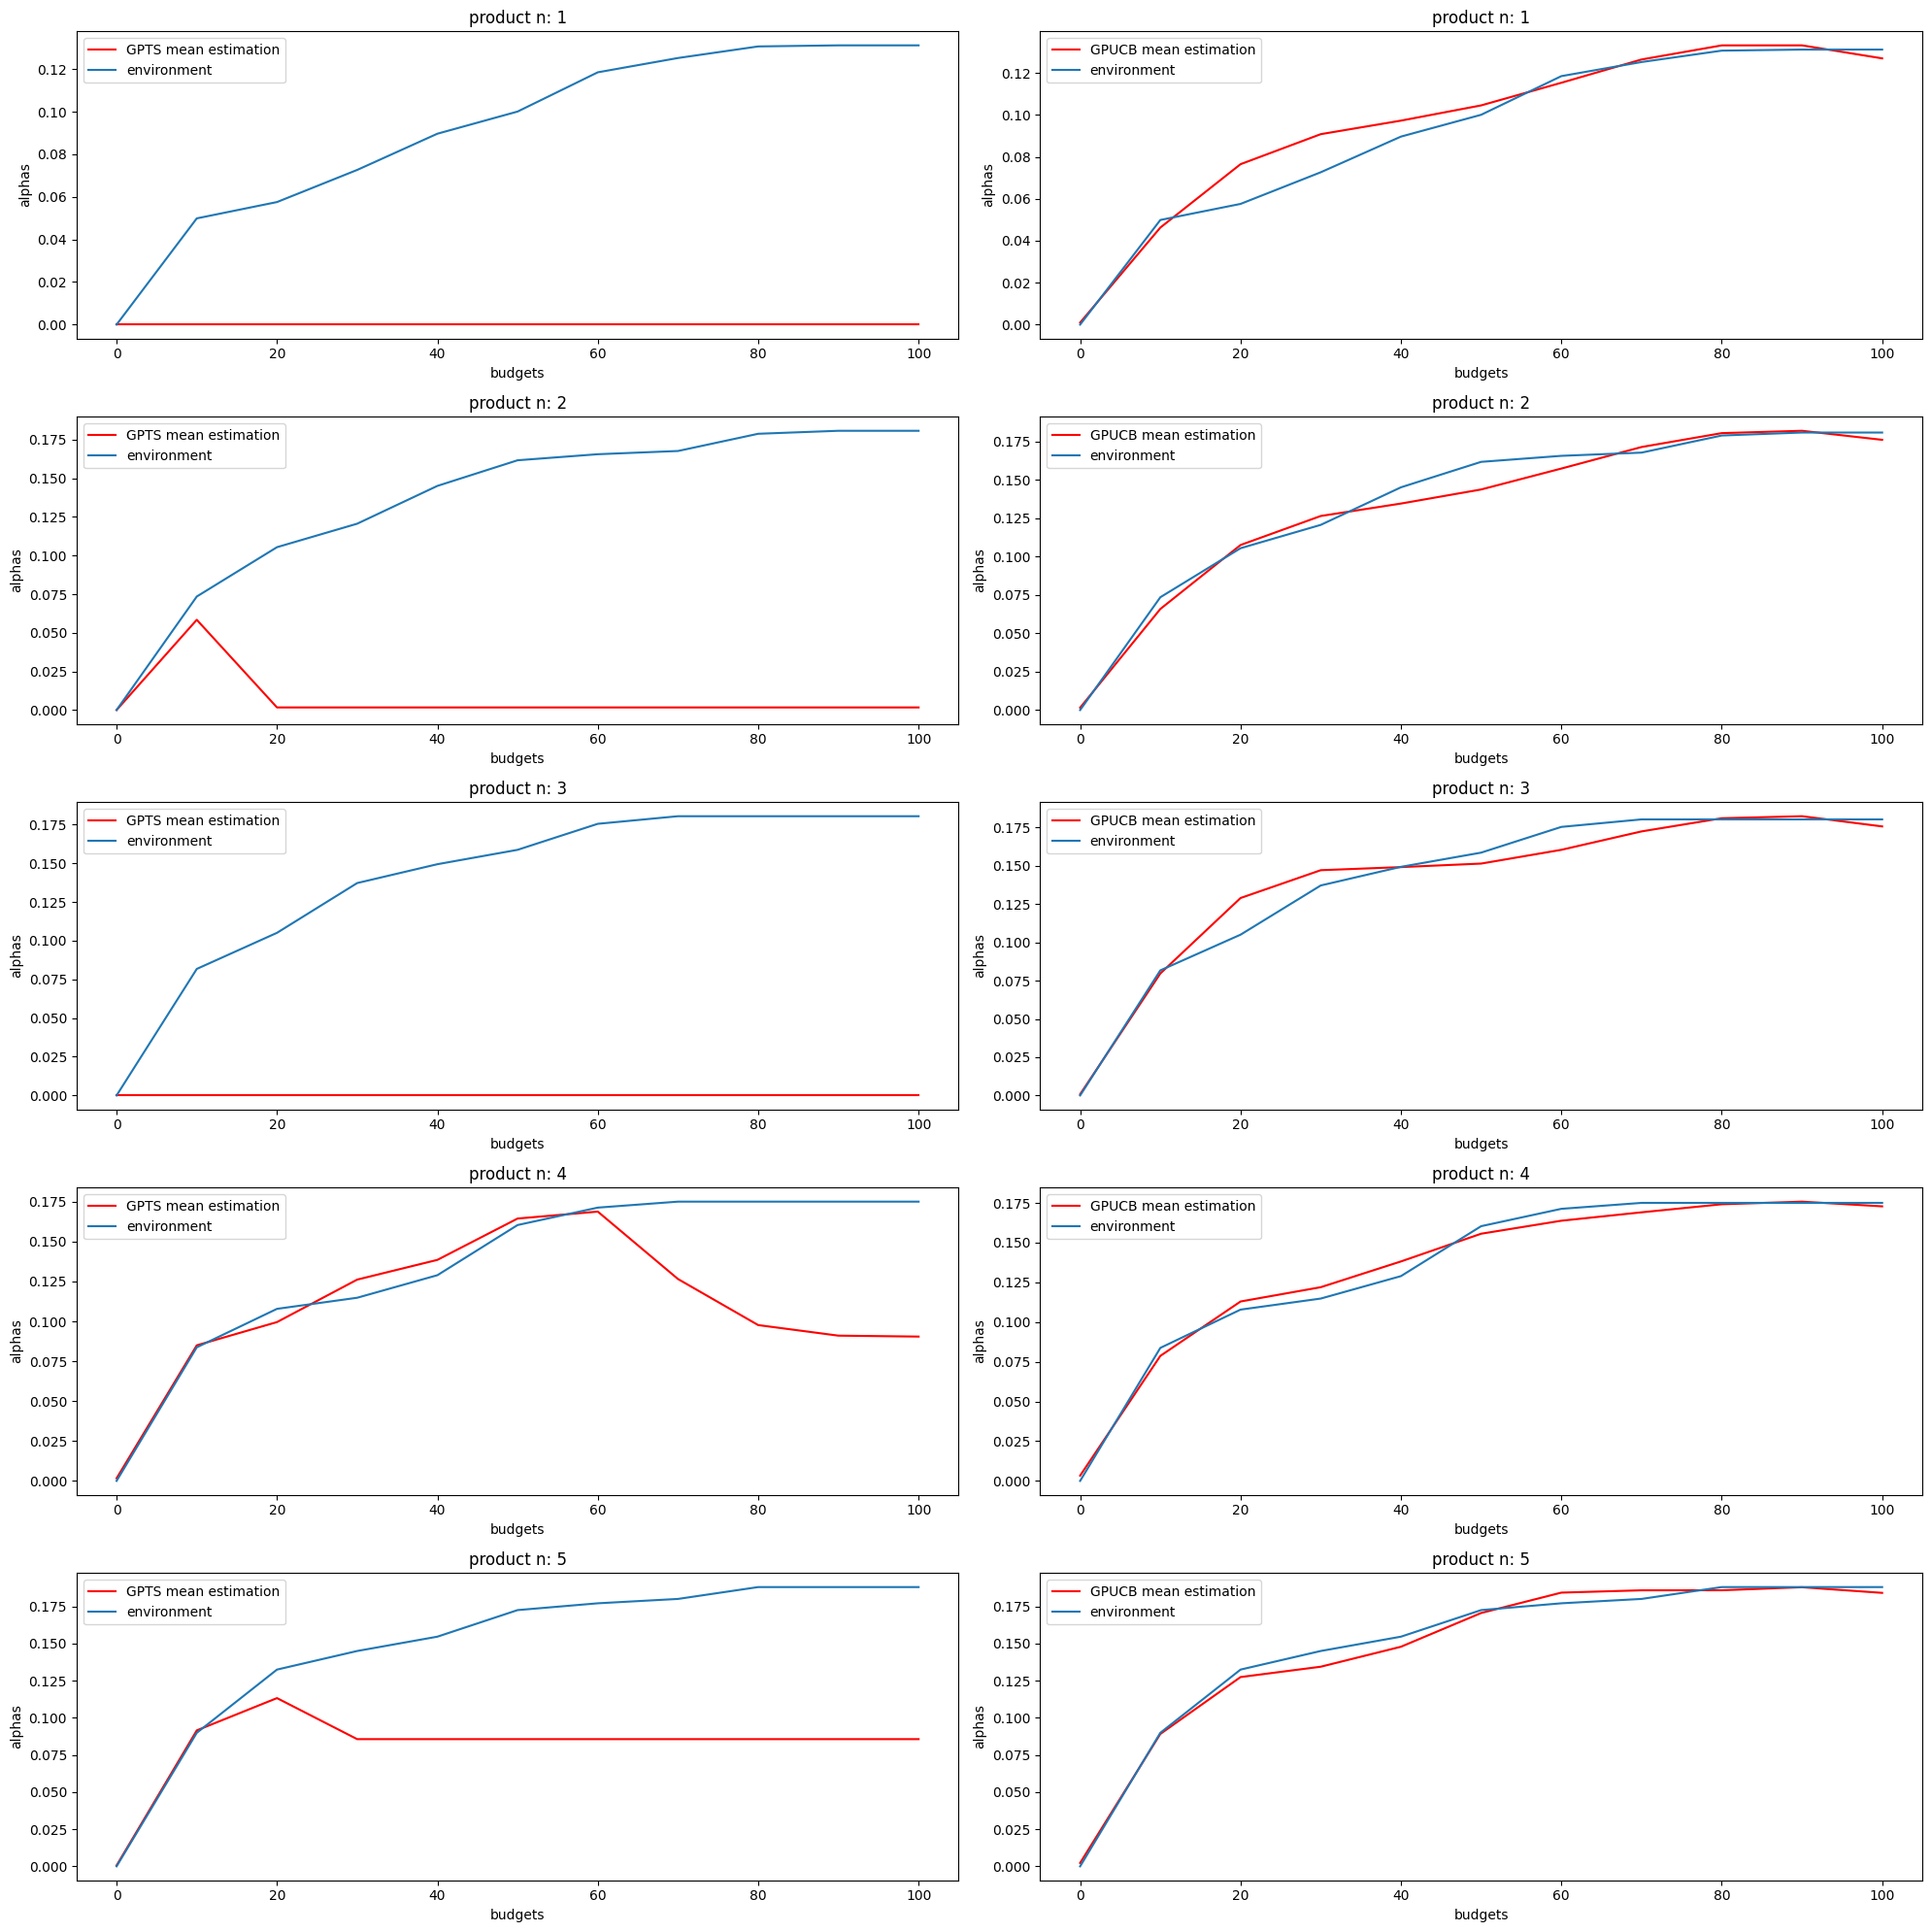

In [2]:
observe_learned_functions()

In [2]:
s = Scenario()

print(s.get_product_prices())
print()
print(s.get_users_reservation_prices())
print()


for res_price in s.get_users_reservation_prices():
    buy = []
    for rp,p in zip(res_price,s.get_product_prices()):
        if p > rp:
            buy.append("Not buy")
        else: 
            buy.append("Buy")
    print(buy)

[25 14 30 50 40]

[[31 24 18 65 50]
 [ 5  1 43 61 26]
 [38 30  9 26 25]]

['Buy', 'Buy', 'Not buy', 'Buy', 'Buy']
['Not buy', 'Not buy', 'Buy', 'Buy', 'Not buy']
['Buy', 'Buy', 'Not buy', 'Not buy', 'Not buy']


In [17]:
np.array(s.get_users_reservation_prices())[np.where(s.get_product_prices()<s.get_users_reservation_prices()[:,i] for i in range(3))]

array([[31, 24, 18, 65, 50]])

## Step 3

In [2]:
gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts = simulate_step3()
plot_regrets(gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts, ["GPTS", "GPUCB"])

Experiment n°: 1


n_iteration: 100%|██████████| 70/70 [04:42<00:00,  4.04s/it]


Experiment n°: 2


n_iteration:  39%|███▊      | 27/70 [01:23<02:23,  3.34s/it]

## Step 4

In [ ]:
gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts = simulate_step4()
plot_regrets(gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts, ["GPTS", "GPUCB"])

## Step 5

In [ ]:
def pull_arm(self, num_sold_items):
        if np.random.binomial(n=1, p= 1 - self.exploration_probability):
            estimated_reward = self.estimate_reward(num_sold_items)    
        else :
            value_per_click = self.compute_value_per_click(num_sold_items)
            estimated_reward = np.multiply(
                np.random.beta(a = 0.5, b = 0.5, size=(NUM_OF_PRODUCTS, self.budgets.shape[0])),
                np.atleast_2d(value_per_click).T
            ) 

        budget_idxs_for_each_product, _ = self.dynamic_knapsack_solver(table=estimated_reward)
        return self.budgets[budget_idxs_for_each_product], np.array(budget_idxs_for_each_product)
gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts = simulate_step5()
plot_regrets(gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts, ["GPTS", "GPUCB"])

## Step 6

In [ ]:
swucb_rewards_per_experiment, cducb_rewards_per_experiment, opts = simulate_step6()
plot_regrets(swucb_rewards_per_experiment, cducb_rewards_per_experiment, opts, ["SWUCB", "CDUCB"])

## Step 7

In [ ]:
gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts = simulate_step7()
plot_regrets(gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts, ["GPTS", "GPUCB"])